In [2]:
# --------- Notebook code to have the same import behavior as .py files --------------
#%reset -f
%reload_ext autoreload
%autoreload 2
import os, sys
if 'notebook_path' not in vars():
    notebook_path = os.getcwd()
os.chdir(os.path.join(notebook_path,".."))
sys.path.append(os.getcwd())
# -----------------------------------------------------------------------------------
#from src.data_modules.impulse_response import ImpulseResponseDataModule

import h5py
import lightning as L
from src.data_modules import MovingImpulseResponseDataModule
from src.cnn_model import cnn_model
#ImpulseResponseDataModule()


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
import os, sys, torch
sys.path.append(os.getcwd())
from lightning.pytorch.loggers import WandbLogger
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torchvision import transforms
from src.data_modules import MovingImpulseResponseDataModule
from src.cnn_model_v2 import cnn_model_v2
import src.data_augmentations as data_augmentations
from torchvision import transforms
#model = cnn_model_v2(scale_cnn_width=2, n_blocks=2, block_width=2000) # from scratch

model = cnn_model_v2.load_from_checkpoint("lightning_logs/xovhkfm1/checkpoints/epoch=16149-step=48450.ckpt", scale_model_width=2, n_blocks=2, block_width=2000) # from check point

#data_path = "./data/datasets/moving_dataset_medium.hdf5"
data_path = "data/datasets/moving_dataset_directivity_medium_extra_val.hdf5"
data_val_path = "data/datasets/moving_dataset_directivity_medium_extra_val2.hdf5"
sound_dir = "./data/reference_data/reference_sounds/"
transform = transforms.Compose([data_augmentations.doppler_aug(max_rel_v=1), data_augmentations.noise_aug(noise_ratio=0.001)])
data_module = MovingImpulseResponseDataModule(data_path,sound_dir,batch_size=50, transform=transform, n_mics_per_batch=5, data_val_path=data_path)



In [22]:
#wandb_logger = WandbLogger(log_model="all")

#checkpoint_callback = ModelCheckpoint(every_n_epochs=50)
trainer = L.Trainer(
    max_epochs=30000,
    accelerator="cuda",
    devices=1,#[1],
    log_every_n_steps=50,
    logger = L.pytorch.loggers.CSVLogger("logs", name="my_exp_name"),
    #terminate_on_nan=True,
 #   callbacks=[checkpoint_callback],
    deterministic=True,
)
trainer.validate(model, datamodule = data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 45.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     val/loss_epoch         0.07344315201044083
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val/loss_epoch': 0.07344315201044083}]

In [44]:
from src.gcc_phat_model import gcc_phat_model
import os, sys, torch
sys.path.append(os.getcwd())
from lightning.pytorch.loggers import WandbLogger
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torchvision import transforms
from src.data_modules import MovingImpulseResponseDataModule
from src.cnn_model_v2 import cnn_model_v2
import src.data_augmentations as data_augmentations
from torchvision import transforms
#model = cnn_model_v2(scale_cnn_width=2, n_blocks=2, block_width=2000) # from scratch

#model = cnn_model_v2.load_from_checkpoint("lightning_logs/xovhkfm1/checkpoints/epoch=16149-step=48450.ckpt", scale_model_width=2, n_blocks=2, block_width=2000) # from check point

#data_path = "./data/datasets/moving_dataset_medium.hdf5"
data_path = "data/datasets/moving_dataset_directivity_medium_extra_val.hdf5"
data_val_path = "data/datasets/moving_dataset_directivity_easy_tiny_val.hdf5"
sound_dir = "./data/reference_data/reference_sounds/"
transform = transforms.Compose([data_augmentations.doppler_aug(max_rel_v=1), data_augmentations.noise_aug(noise_ratio=0.001)])
data_module = MovingImpulseResponseDataModule(data_path,sound_dir,batch_size=50, transform=transform, n_mics_per_batch=5, data_val_path=data_val_path)



model = gcc_phat_model(data_module.n_shift_bins,data_module.max_shift, data_module.sample_length, temperature_scaling=10)

trainer = L.Trainer(accelerator="cpu")
trainer.validate(model, data_module)



GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/er6236te/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 15.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     val/loss_epoch          6.158205986022949
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val/loss_epoch': 6.158205986022949}]

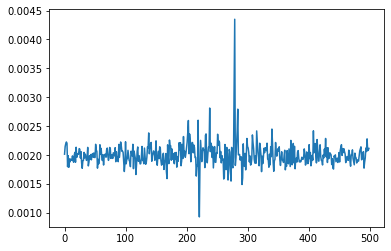

In [55]:
import matplotlib.pyplot as plt
X,y = next(iter(data_module.val_dataloader()))
pred = model(X)

plt.plot((5e-1*pred[0]).softmax(dim=0))

In [3]:
data_path = "./data/datasets/moving_dataset_small.hdf5"
sound_dir = "./data/reference_data/reference_sounds/"
data_module = MovingImpulseResponseDataModule(data_path,sound_dir,batch_size=2)

model = cnn_model()
data_module.setup()
X,y = next(iter(data_module.train_dataloader()))


In [59]:
# doppler augmentation. 
import torch
import matplotlib.pyplot as plt
#plt.figure(figsize=(16,6))
#plt.plot(X[0,0,200:500],'.')

class doppler_aug(object):

    def __init__(self, max_rel_v = 3):
        self.max_rel_v = max_rel_v

    def __call__(self, sample):
        X,y = sample
        factor = (2*self.max_rel_v*torch.rand(1) + 343 - self.max_rel_v)/343

        freqs = X.shape[-1]
        if factor < 1:
            x = torch.arange(freqs)*factor
            w_lower = 1 - (x - x.int())
            X[:,0::2] = X[:,0::2,x.int()]*w_lower + (1 - w_lower)*X[:,0::2,x.int()+1]
        else:
            x = torch.arange(freqs)*factor
            x = x[x < freqs - 1] # make sure we don't query freq values outside of input vector
            w_lower = 1 - (x - x.int())
            
            X[:,0::2,:x.shape[0]] = X[:,0::2,x.int()]*w_lower + (1 - w_lower)*X[:,0::2,x.int()+1]
            X[:,0::2,x.shape[0]:] = 0

        return X,y

class noise_aug(object):

    def __init__(self, noise_ratio = 0.01):
        self.noise_ratio = noise_ratio

    def __call__(self, sample):
        X,y = sample
        X += self.noise_ratio*X.std(dim=(1,2),keepdim=True)*torch.randn(X.shape)
        return X,y


#plt.plot(X[0,0,2000:2500],'.')



#(torch.arange(2500)*factor).int()
#(torch.arange(2500)*factor).int() + 1


In [ ]:
# noise augmentation



In [ ]:


# from pytorch_lightning.loggers import WandbLogger
# wandb_logger = WandbLogger(log_model="all")
# trainer = L.Trainer(
#     max_epochs=50,
#     accelerator="cuda",
#     devices=1,
#     logger=wandb_logger,
# )
# trainer.fit(model, data_module)

In [5]:
import torch
data_path = "./data/datasets/moving_dataset_medium.hdf5"
with h5py.File(data_path, "r") as f:
    print(f["input"].shape)
    print(f.attrs.keys())
    X = f["input"]
    print(torch.tensor(X[:30]).shape)
    print(torch.tensor(X[:30]).std(dim=(1,2,3)).shape)


(3200, 51, 10, 1600)
<KeysViewHDF5 ['fs', 'n_mics', 'n_rooms', 'reflection_coeff', 'rir_len', 'room_max_size', 'room_min_size', 'scatter_coeff', 'sound_source_locations', 'sound_source_max_move', 'speed_of_sound', 'target_path']>
torch.Size([30, 51, 10, 1600])
torch.Size([30])


In [219]:
batch = next(iter(data_module.train_dataloader()))
X,y = batch

import glob
import torch

from scipy.io import wavfile
sample_length: int = 10000 #number of samples
max_freq: float = 4000.0 # Hz
batch_size : int = 1
n_mics_per_batch = 17
max_shift : float = 500 #samples
n_shift_bins : int = 500
validation_percentage = 0.05

# remove
dataset_metadata = data_module.h5file.attrs
dataset = data_module.dataset
sound_files = glob.glob(sound_dir + "*.wav")

#const
rir_len = dataset_metadata["rir_len"]
batch_size = X.shape[0]
n_sound_positions = X.shape[2]
sim_sample_length = sample_length + rir_len # length used when simmulating sound, needs to be longer than the final sound to have echo in the entire sample


# randomly select audio pieces

signals = torch.zeros(batch_size,sim_sample_length)
for batch_i in range(batch_size):
    sound_file = sound_files[torch.randint(len(sound_files),(1,))]
    fs, signal = wavfile.read(sound_file)
    if fs != dataset_metadata["fs"]:
        raise Exception("Please use .wav with the same sampling frequency as the simmulated impulse responses sampling frequency (probably 16 kHz")
    start = torch.randint(len(signal) - sim_sample_length, (1,))
    signals[batch_i,:] = torch.tensor(signal[start : start + sim_sample_length])
piece_length = signals.shape[1] // n_sound_positions
signals = signals[:,:piece_length*n_sound_positions].reshape(batch_size, n_sound_positions, piece_length) # splitting the sound into the different speaker positions
#signals = torch.concatenate([signals, torch.zeros(signals.shape[0], signals.shape[1], rir_len)],dim=2)

signals = torch.fft.irfft(torch.fft.rfft(X, signals.shape[2] + rir_len) * torch.fft.rfft(signals, signals.shape[2] + rir_len).unsqueeze(1))

fin_signal = torch.zeros(batch_size, n_mics_per_batch, signals.shape[3] + piece_length*(n_sound_positions-1))
for i in range(n_sound_positions):
    fin_signal[:,:,i*piece_length:piece_length*i+signals.shape[3]] = signals[:,:,i]

fin_signal = fin_signal[:,:,-sample_length:]
max_freq_component = int(max_freq*sample_length/dataset_metadata["fs"])

fin_signal = torch.fft.rfft(fin_signal)[:,:,:max_freq_component].unsqueeze(2)
fin_signal = torch.concatenate([torch.concatenate([fin_signal, fin_signal.roll(i + 1, 1)], dim=2) for i in range((n_mics_per_batch-1) // 2)],dim=1)  # organize sounds pairwise, 
# NOTE: if n_mics_per_batch is not odd, then we will compute all pairs of microphones except one
fin_signal = fin_signal.view(batch_size * fin_signal.shape[1],2,fin_signal.shape[3])
fin_signal = torch.concatenate([fin_signal.real, fin_signal.imag], dim=1)

y = torch.concatenate([y - y.roll(i + 1, 1) for i in range((n_mics_per_batch-1) // 2)], dim=1).view(-1) # compute pairwise distance-difference
y *= dataset_metadata["fs"]/dataset_metadata["speed_of_sound"] # rescale distance-difference to sample_difference

bin_edges = torch.linspace(-max_shift,max_shift,n_shift_bins+1)
bin_edges[0] = -float("inf")
bin_edges[-1] = float("inf")
y = (y.unsqueeze(1) < bin_edges).to(torch.long).argmax(dim=1) - 1  # Bins the values in y, since argmax finds first occurence where condition is met.



#torch.fft.irfft(torch.fft.rfft().unsqueeze(1) * torch.fft.rfft(X, signals.shape[2]))



torch.Size([680])

In [143]:
dataset_metadata["speed_of_sound"]

343.0

In [ ]:
def format_simulated_data(X, y):
            """
            transform a tensor of impulse responses in different rooms into pairwise TimeEstimation-problems. Note (X and y should be on GPU)

            """
            # pull a random sound
            sound_paths = glob(os.path.join(reference_sound_folder, "*.wav"))
            # simulate longer sound and then cut to the relevant piece
            signals = np.zeros(
                (X.shape[0], config["sample_length"] + config["rir_len"] - 1)
            )
            for i in range(X.shape[0]):
                sound_path = sound_paths[np.random.randint(len(sound_paths))]
                fs, signal = wavfile.read(sound_path)
                start = np.random.randint(
                    0, len(signal) - config["sample_length"] - config["rir_len"] - 1
                )
                signals[i, :] = signal[
                    start : start + config["sample_length"] + config["rir_len"] - 1
                ]
            # signals = torch.tensor(signals).to(torch.float32).to(device).unsqueeze(1)
            signals = torch.tensor(signals).to(torch.float32).unsqueeze(1)

            q = torch.fft.irfft(
                torch.fft.rfft(signals) * torch.fft.rfft(X, signals.shape[2])
            )[
                :, :, : config["sample_length"]
            ]  # compute the heard sound, and cut it to the right length
            q = torch.fft.rfft(q)[
                :, :, : config["max_freq"]
            ]  # cut frequencies which are too high
            q = q.unsqueeze(2)
            q = torch.concatenate(
                [
                    torch.concatenate([q, q.roll(i + 1, 1)], dim=2)
                    for i in range(config["mics_per_batch"] // 2)
                ],
                dim=1,
            )  # organize sounds pairwise
            q = q.view(
                X.shape[0]
                * (config["mics_per_batch"] * (config["mics_per_batch"] - 1))
                // 2,
                2,
                -1,
            )  # reshape so that each example is a row
            X = torch.concatenate([q.real, q.imag], dim=1)
            X /= (
                X.std(dim=2).mean(dim=1).unsqueeze(1).unsqueeze(2) + 1e-5
            )  # avoid dividing by 0
            y = (
                torch.concatenate(
                    [
                        y - y.roll(i + 1, 1)
                        for i in range(config["mics_per_batch"] // 2)
                    ],
                    dim=1,
                ).view(-1)
                * fs
                / 343
            )  # compute gt for all pairs
            y = y_to_class_gt(y, config["guess_grid_size"], config["max_shift"]).to(
                torch.long
            )

            return X, y

In [10]:
data_module.dataset.X

<HDF5 dataset "input": shape (10, 51, 10, 1600), type "<f4">

In [4]:


with h5py.File("./test.hdf5","w") as f:
    f.create_dataset("metadata",())
    z = f["metadata"]
    #metadata = z.attrs
    f.attrs["a"] = 43
    #metadata.create("a",123)




In [5]:
from torch.utils.data import DataLoader
import torch
with h5py.File("./data/datasets/example_moving.hdf5","r") as f:
    X = f["input"]
    #torch.utils.data.IterableDataset(X)
    print(DataLoader(X))
    torch.utils.data.Subset(X,torch.arange(5))
    #metadata = z.attrs
    #for i in f.attrs:
    #    print(f'{i} : {f.attrs[i]}')
    #print(f.attrs["a"])


In [29]:
def f(x,y):
    print(locals())
    print(vars()['x'])

f(1,2)

{'x': 1, 'y': 2}
1
